In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random


In [20]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [21]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 2520 

Raw test dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 372 



In [22]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [23]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [24]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

In [25]:
get_label_name = dataset_info.features['label'].int2str

In [27]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [28]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

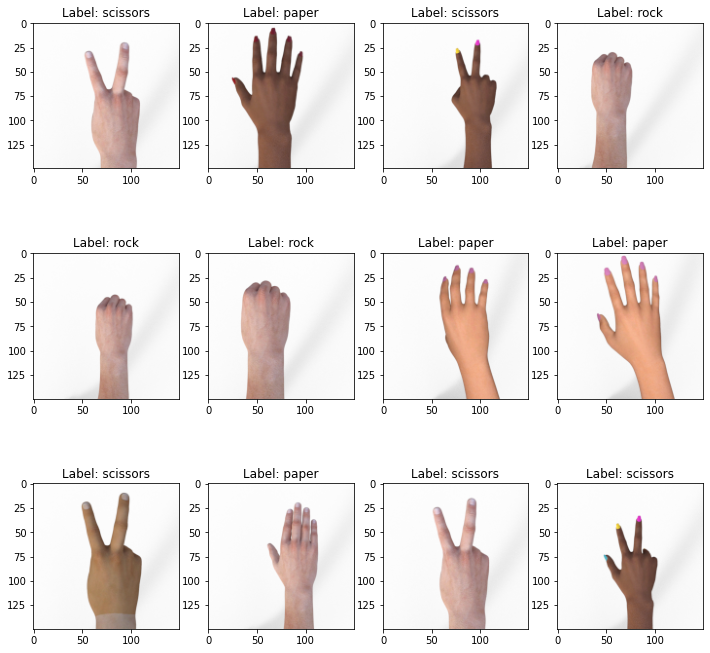

In [29]:
preview_dataset(dataset_test)

In [30]:
BATCH_SIZE = 32

dataset_train_shuffled = dataset_train.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_shuffled = dataset_train.batch(
    batch_size=BATCH_SIZE
)

dataset_train_shuffled = dataset_train_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [31]:
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Convolution2D(
    input_shape=INPUT_IMG_SHAPE,
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Second convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Third convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Fourth convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Flatten the results to feed into dense layers.
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

# Output layer.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

In [32]:
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [33]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 78
validation_steps: 11


In [38]:
training_history = model.fit(
    x=dataset_train_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/15
78/78 [==============================] - 180s 2s/step - loss: 0.0679 - accuracy: 0.9916 - val_loss: 0.4025 - val_accuracy: 0.9034
Epoch 2/15
78/78 [==============================] - 178s 2s/step - loss: 0.1026 - accuracy: 0.9932 - val_loss: 0.3918 - val_accuracy: 0.9290
Epoch 3/15
78/78 [==============================] - 178s 2s/step - loss: 2.8140e-05 - accuracy: 1.0000 - val_loss: 0.6521 - val_accuracy: 0.8977
Epoch 4/15
78/78 [==============================] - 179s 2s/step - loss: 7.9735e-07 - accuracy: 1.0000 - val_loss: 0.9098 - val_accuracy: 0.8778
Epoch 5/15
78/78 [==============================] - 180s 2s/step - loss: 0.0246 - accuracy: 0.9964 - val_loss: 0.7790 - val_accuracy: 0.8551
Epoch 6/15
78/78 [==============================] - 178s 2s/step - loss: 2.8181e-04 - accuracy: 1.0000 - val_loss: 1.0255 - val_accuracy: 0.8807
Epoch 7/15
78/78 [==============================] - 179s 2s/step - loss: 0.0076 - accuracy: 0.9984 - val_loss: 3.1677 - val_accuracy: 0.7443
E

In [39]:
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

12/12 [==============================] - 7s 561ms/step - loss: 1.7955 - accuracy: 0.9032


In [40]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  1.9867892220304384e-08
Training accuracy:  1.0


Test loss:  1.795512318611145
Test accuracy:  0.9032257795333862
